# Synthetic Data Fit

In [1]:
from drdmannturb.calibration import CalibrationProblem
from drdmannturb.data_generator import OnePointSpectraDataGenerator
from drdmannturb.shared.parameters import NNParameters, ProblemParameters, LossParameters, PhysicalParameters

import torch
import torch.nn as nn
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu" 

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

L = 0.59

Gamma = 3.9
sigma = 3.4

domain = torch.logspace(-1, 2, 20)

In [2]:
pb = CalibrationProblem(
    nn_params = NNParameters(
        activations = [nn.GELU(), nn.GELU()], 
    ),
    prob_params = ProblemParameters(nepochs=5),
    loss_params = LossParameters(),
    phys_params = PhysicalParameters(
        L=0.59,
        Gamma=3.9,
        sigma=3.4,
        domain=domain
    ), 
    device=device
)

/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
parameters = pb.parameters
parameters[:3] = [
    np.log(L),
    np.log(Gamma),
    np.log(sigma)
]

pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = domain
DataPoints = [(k1, 1) for k1 in k1_data_pts]

In [4]:
Data = OnePointSpectraDataGenerator(data_points=DataPoints).Data

In [5]:
pb.eval(k1_data_pts)
pb.calibrate(data=Data)


Calibrating MannNet...
torch.Size([80])
Initial loss:  0.12235743160363866

[Calibration.py -- calibrate]-> Epoch 0

loss  =  0.12235743160363866
loss  =  0.07394234735841006
loss  =  0.06697836302428778
loss  =  0.0613506573821104
loss  =  0.037518263924801315
loss  =  0.037509489872783235
loss  =  0.037434040485486646
loss  =  0.037028791718654044
loss  =  0.03701619068379716
loss  =  0.036917313707806265
loss  =  0.03686260940215436
loss  =  0.036497824773567465
loss  =  0.036409280970428184
loss  =  0.0360382560490306
loss  =  0.035365349958567605
loss  =  0.037450982109336256
loss  =  0.033894759802980415
loss  =  0.03358903685203174
loss  =  0.03310781264806104
loss  =  0.03125622287152846
loss  =  0.030248840358648846
loss  =  0.025897468216417526
loss  =  0.025600663148130667
loss  =  0.024375871379292348
loss  =  0.02414378827882456
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1



/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


loss  =  0.02414378827882456
loss  =  0.02412345915362407
loss  =  0.024005910804719113
loss  =  0.023993977050133865
loss  =  0.02394501819849536
loss  =  0.023896157043489404
loss  =  0.02362099591199139
loss  =  0.02359190752838712
loss  =  0.023484660851974266
loss  =  0.023421164276038915
loss  =  0.023367255880032398
loss  =  0.02313274859286435
loss  =  0.023126344401606668
loss  =  0.023073487710885358
loss  =  0.023031583860201977
loss  =  0.022807012096915838
loss  =  0.022786362375953932
loss  =  0.022771999000606072
loss  =  0.022686378104849886
loss  =  0.02267001469011463
loss  =  0.022605068551294603
loss  =  0.022544617657260093
loss  =  0.02230267149689398
loss  =  0.02205380849671163
loss  =  0.023232206990770193
loss  =  0.02169880777748434
---------------------------------



[Calibration.py -- calibrate]-> Epoch 2

loss  =  0.02169880777748434
loss  =  0.021552775575510524
loss  =  0.021312021658635674
loss  =  0.020899881162678643
loss  =  0.02051520198718476
loss

array([-0.46371886,  0.7016636 ,  0.99618619, -0.48040014,  0.03160094,
       -0.31480277, -0.35292628, -0.1119053 , -0.44120634, -0.10544836,
       -0.27509653, -0.28118879, -0.16064688,  0.95995352, -0.39488487,
       -0.31660306, -0.18178986, -0.10331088,  0.1716212 , -0.27617113,
        0.45130193,  0.02497687, -0.37858854, -0.32163756,  1.06283702,
       -0.66131152,  0.11228901, -0.30502507, -0.14561507, -0.24716106,
       -1.82198321, -0.10315809,  1.05857157, -0.09211576,  0.31070274,
        0.06991735,  0.13669878,  0.25351304, -0.06923613,  0.13574421,
       -0.03160679,  0.18465504,  0.38401628, -0.06370992,  0.22258909,
        0.30718511, -0.4782653 ,  0.13461705,  0.48082882, -0.20267769,
        1.64199985, -0.05168654, -1.33994232, -0.24579645, -0.1666282 ,
       -0.24447189,  0.62519131, -0.13004424, -0.50730826,  0.09982176,
        0.64391846, -0.00360818, -0.34156059, -0.17325121, -0.08384131,
       -0.28473809,  0.0785896 , -0.22168091, -0.2602363 , -0.20

k1.size: torch.Size([20])   self.kF_data_vals: torch.Size([80])


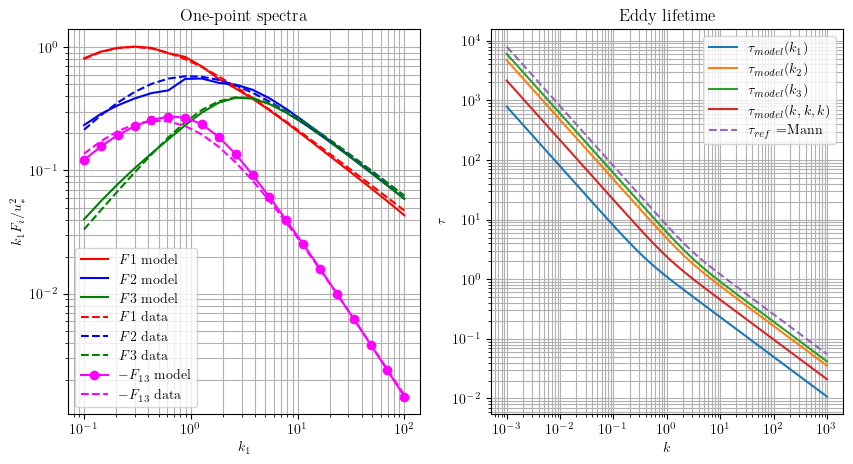

In [6]:
pb.plot(plt_dynamic=False)

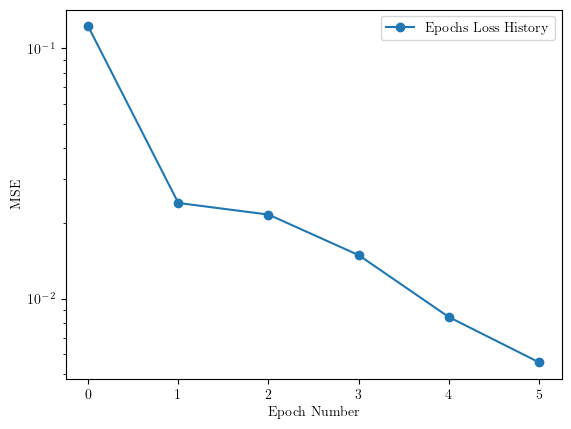

In [7]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend()
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show()
